# **Setup**

In [1]:
%load_ext autoreload
%autoreload 2

from ngram_train.word2vec import train_models, evaluate_models, plot_evaluation_results
from ngram_prep.utilities.notebook_logging import setup_notebook_logging
from ngram_train.word2vec import run_regression_analysis, plot_regression_results

In [ ]:
src_path = '/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files'

setup_notebook_logging(
    workflow_name="training_workflow",
    console=False
)

train_models(
    corpus_path=src_path,
    dir_suffix='test',
    years=(1900, 2015),
    year_step=5,
    weight_by=('none',),
    vector_size=(100, 200, 300),
    window=(4,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(5, 10, 15, 20, 25, 30),
    max_parallel_models=13,
    workers_per_model=3,
    mode="resume",
    unk_mode="strip",
    use_corpus_file=True
)


Scanning for existing models...


Scanning existing models: 100%|██████████| 147/147 [00:00<00:00, 245.51 files/s]

  Valid models found:    147
  Invalid/partial:       0

WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-07 16:08:08

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             .../edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/5grams_pivoted.db
Model directory:      /vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Log directory:        .../edk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_test/training
Parallel models:      13

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2015 (step=5, 24 years)
Weighting:            ('none',)
Vector size:          (100, 200, 300)
Context window:       (4,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training epoc

  Created corpus file for year 1945, weight_by=none: /state/partition1/job-1678596/w2v_corpus_y1945_wbnone__3q6vqv5.txt
  Created corpus file for year 1940, weight_by=none: /state/partition1/job-1678596/w2v_corpus_y1940_wbnone_e8biex4v.txt
  Created corpus file for year 1935, weight_by=none: /state/partition1/job-1678596/w2v_corpus_y1935_wbnone_5t6xb_qq.txt
  Created corpus file for year 1950, weight_by=none: /state/partition1/job-1678596/w2v_corpus_y1950_wbnone_gt792rnm.txt
  Created corpus file for year 1955, weight_by=none: /state/partition1/job-1678596/w2v_corpus_y1955_wbnone_z7rre79o.txt
  Created corpus file for year 1960, weight_by=none: /state/partition1/job-1678596/w2v_corpus_y1960_wbnone_sfw0zabd.txt
  Created corpus file for year 1965, weight_by=none: /state/partition1/job-1678596/w2v_corpus_y1965_wbnone_gwlhu65l.txt
  Created corpus file for year 1975, weight_by=none: /state/partition1/job-1678596/w2v_corpus_y1975_wbnone_i8a8n4rl.txt
  Created corpus file for year 1980, wei

Training Models:   3%|▎         | 8/285 [1:27:20<37:02:35, 481.43s/ models]

In [2]:
mod_path = '/vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files'

setup_notebook_logging(
    workflow_name="evaluation_workflow",
    data_path=mod_path,
    console=False
)

evaluate_models(
    model_dir=mod_path,
    dir_suffix='test',
    eval_dir=mod_path,
    save_mode='overwrite',
    run_similarity=True,
    run_analogy=False
)


WORD2VEC MODEL EVALUATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-07 15:00:57

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Model directory:      /vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Evaluation file:      ...LP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv
Log directory:        ...dk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_test/evaluation
Save mode:            overwrite

Evaluation Datasets
────────────────────────────────────────────────────────────────────────────────────────────────────
Similarity dataset:   ...miniforge/lib/python3.11/site-packages/gensim/test/test_data/wordsim353.tsv
Analogy dataset:      ...orge/lib/python3.11/site-packages/gensim/test/test_data/questions-words.txt

Found 147 models to evaluate



Evaluating models: 100%|██████████| 147/147 [00:00<00:00, 224.10 models/s]


Evaluation Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models evaluated:     147
Results saved to:     ...LP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



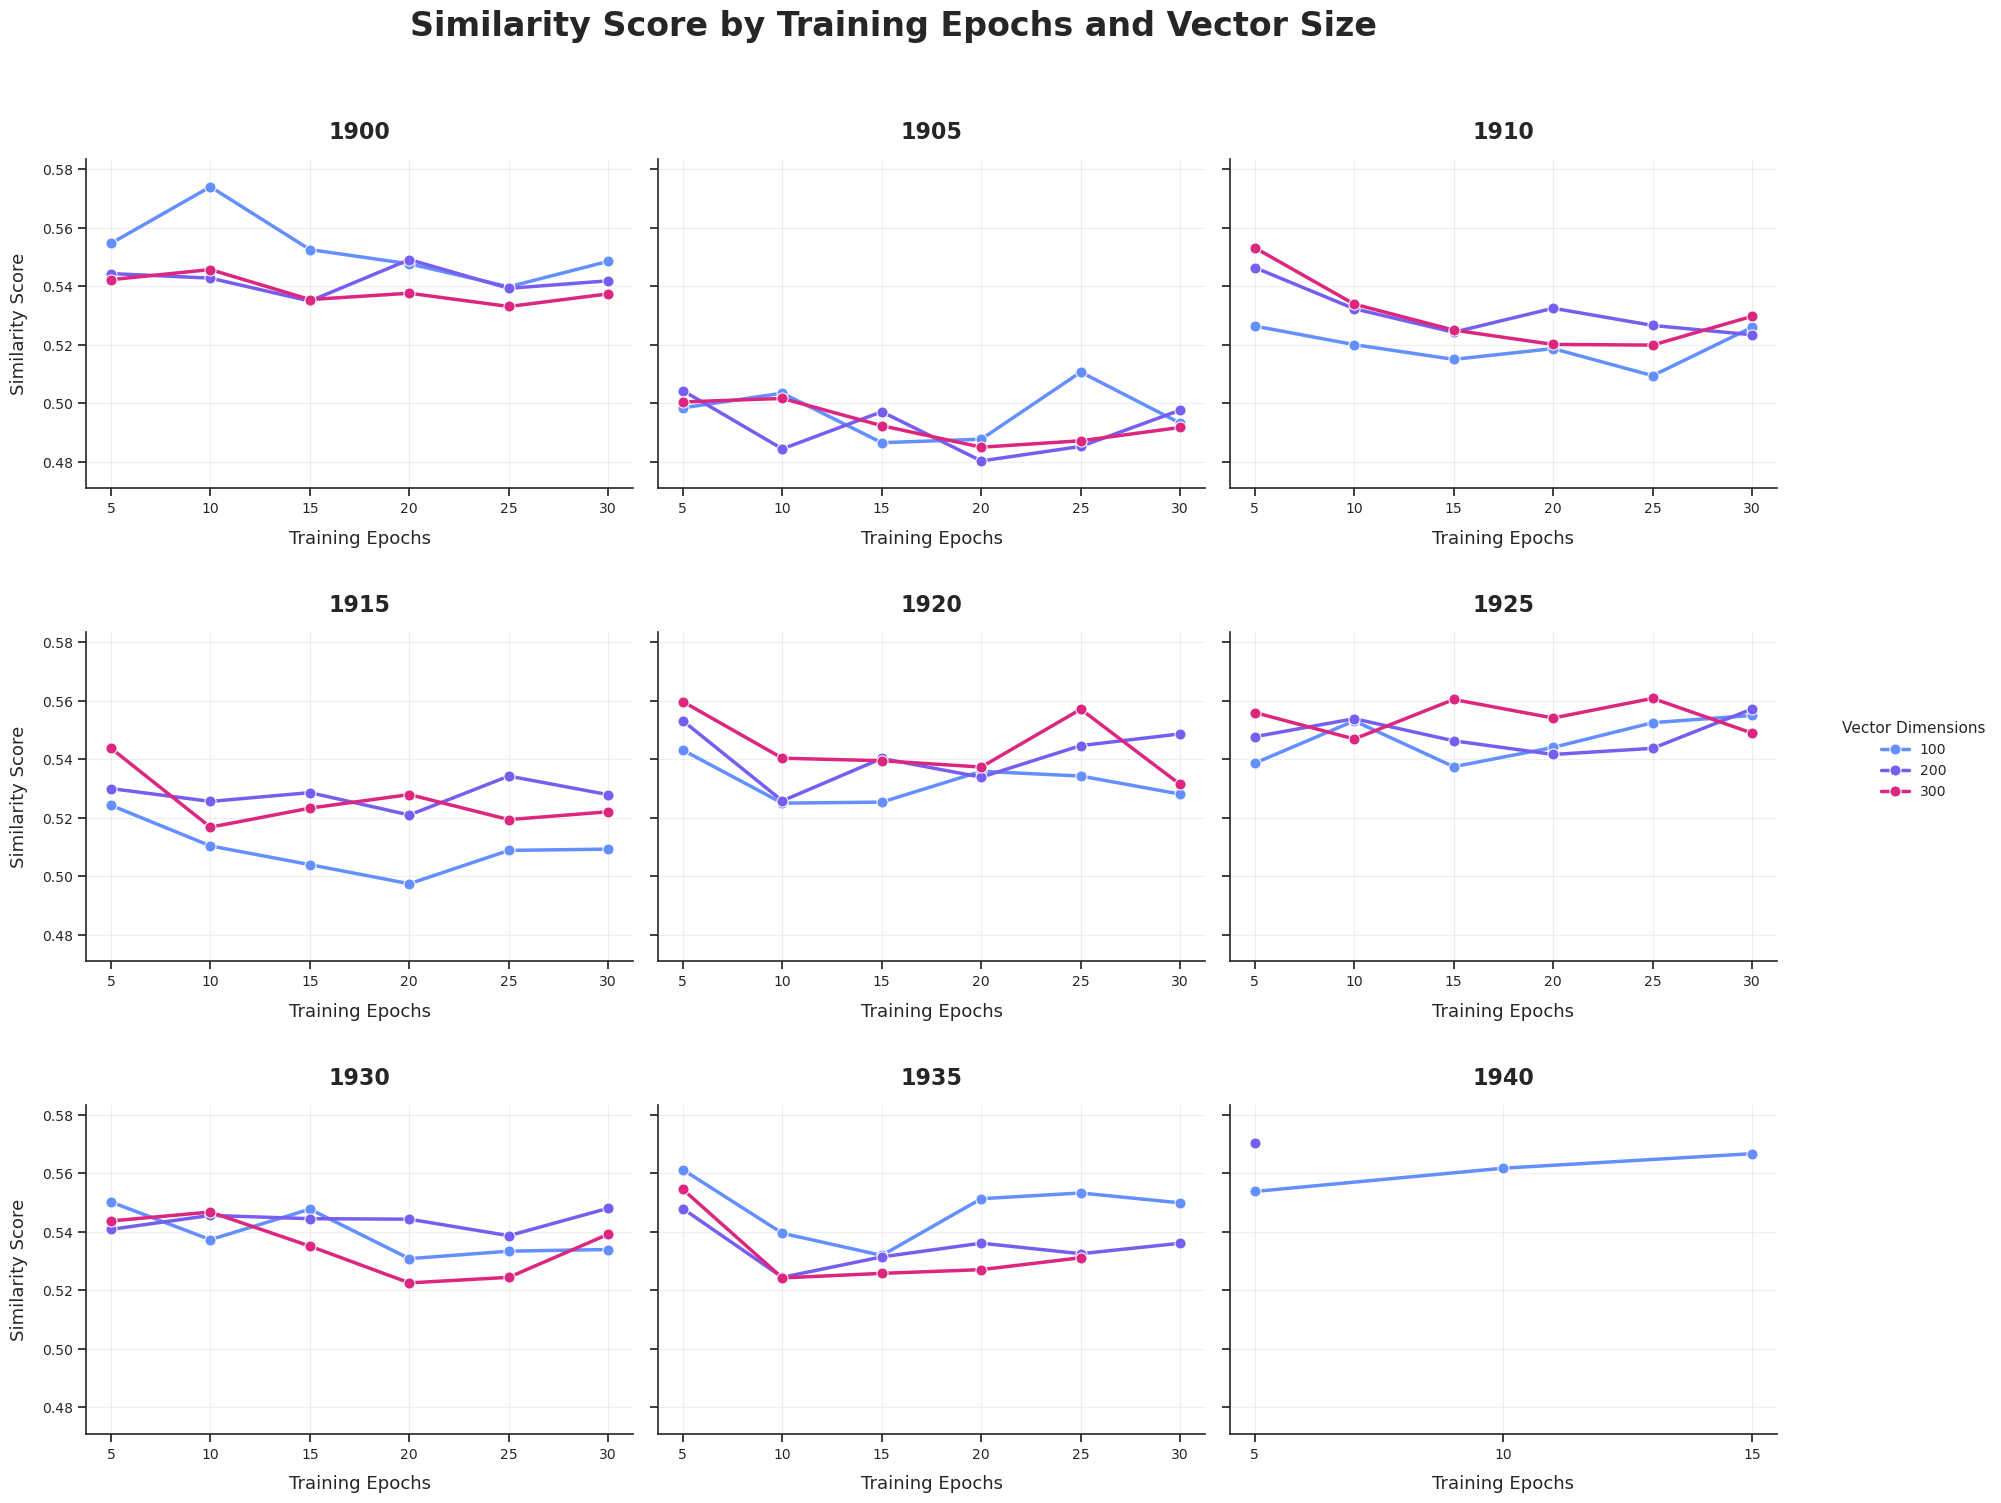

In [11]:
eval_file = '/vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

plot_evaluation_results(
    csv_file=eval_file,
    verbose=False,
    metric='similarity_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Similarity Score by Training Epochs and Vector Size'
)

Loading data...
Loaded 147 observations
Number of years: 9

Model specification:
  Formula: similarity_score ~ scale(year) + scale(vector_size) + scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Model converged successfully!

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: similarity_score
No. Observations: 147     Method:             REML            
No. Groups:       9       Scale:              0.0001          
Min. group size:  4       Log-Likelihood:     439.3103        
Max. group size:  18      Converged:          Yes             
Mean group size:  16.3                                        
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.533    0.006 94.853 0.000  0.522  0.544
scale(year)          0.010    0.005  1.954 0.051 -0.000  0.020
scale(vecto

/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


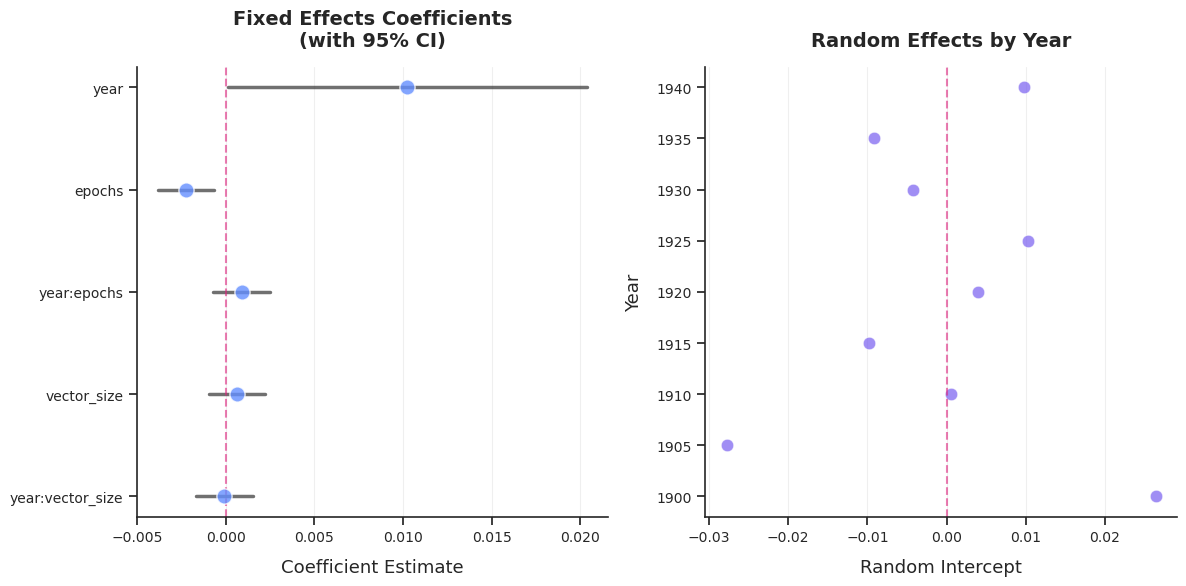

In [4]:
eval_file = '/vast/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

results = run_regression_analysis(
    csv_file=eval_file,
    outcome='similarity_score',
    predictors=['year', 'vector_size', 'epochs']
)

results = run_regression_analysis(
    csv_file=eval_file,
    outcome='similarity_score',
    predictors=['year', 'vector_size', 'epochs', 'approach'],
    interactions=[('year', 'vector_size'), ('year', 'epochs')],
)

plot_regression_results(results)
